In [12]:
using QuantumOptics
using PyPlot

#### Rabi oscillations

Hamiltonian driven by field

$\hat{H} = \omega_0 \left|e\right> \left<e\right| + \Omega \cos\omega t\left( \left|g\right> \left<e\right| + \left|e\right> \left<g\right|\right)$



Hamiltonian in rotating frame

$\hat{H} = \frac{\Omega}{2}\left(1 + e^{-2 i \omega_0 t} \right) \left|g\right>\left<e\right| + \frac{\Omega}{2}\left(1 + e^{2 i \omega_0 t} \right) \left|e\right>\left<g\right|$



RWA

$\hat{H} = \frac{\Omega}{2}\left(\left|g\right>\left<e\right| + \left|e\right>\left<g\right|\right)$



In [3]:
b = NLevelBasis(2);
g = nlevelstate(b, 1);
e = nlevelstate(b, 2);

Ω = 1.0 * 2*π;
tspan = [0.0:0.01:3.0;];
ψ0 = g;
Δ = 0.0 * 2*π;


function Rabi(Δ)
    H = -Δ * e ⊗ dagger(e) + Ω/2 * (g ⊗ dagger(e) + e ⊗ dagger(g));
    tout, ψ = timeevolution.schroedinger(tspan, ψ0, H);
    plot(tspan, expect(e ⊗ dagger(e), ψ), label="Δ = $Δ");
end;

/Users/goloshch/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


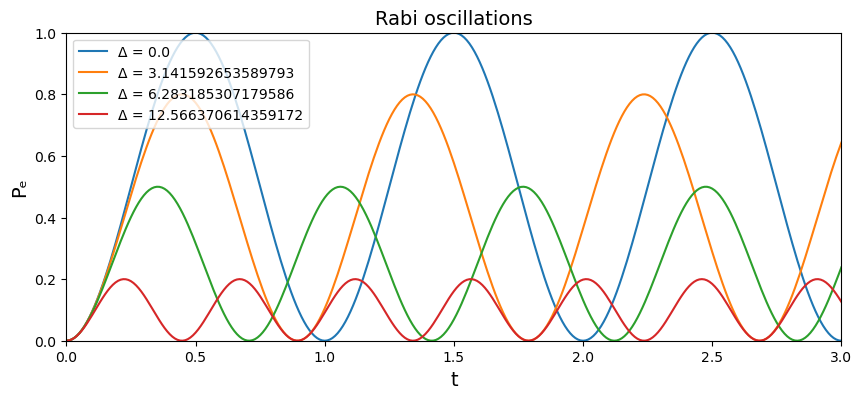

PyObject <matplotlib.legend.Legend object at 0x14649b0a0>

In [4]:
figure(figsize=(10,4))
Rabi(0.0);
Rabi(1π);
Rabi(2π);
Rabi(4π);

xlabel("t", fontsize=14)
ylabel("Pₑ", fontsize=14)
xlim(0.0, 3.0);
ylim(0.0, 1.0);
title("Rabi oscillations", fontsize=14)
legend()

#### Bloch-Siegert shift

Bloch-Siegert shift reduces Rabi oscillations resonance amplitude as $\left(\frac{\Omega}{\sqrt{\Omega^2+\delta\omega^2}}\right)^2 = \frac{1}{1+(\delta\omega/\Omega)^2}$. 

Analytic expression for Bloch-Siegert shift: $\delta \omega = \frac{\Omega^2}{4\omega}$

In [29]:
function BlochSiegert(ω, Ω)
    b = NLevelBasis(2);
    g = nlevelstate(b, 1);
    e = nlevelstate(b, 2);
    ψ0 = g;
    
    tspan = [0.0:0.01:20.0;];
    
    H = TimeDependentSum(
    [t->Ω/2*(1.0 .+ exp(2im * ω * t)), t->Ω/2*(1.0 .+ exp(-2im * ω * t))],
    [e ⊗ dagger(g),g ⊗ dagger(e)]);

    H_RWA = Ω/2 * (e ⊗ dagger(g) + g ⊗ dagger(e));

    tout, ψ = timeevolution.schroedinger_dynamic(tspan, ψ0, H; abstol=1e-12, reltol=1e-10);
    tout, ψ_RWA = timeevolution.schroedinger(tspan, ψ0, H_RWA);
    
    return tspan, ψ, ψ_RWA
end;

In [30]:
tspan, ψ1, ψ_RWA = BlochSiegert(0.5 * 2*π, 1.0 *2*π);
tspan, ψ2, ψ_RWA = BlochSiegert(1.0 * 2*π, 1.0 *2*π);
tspan, ψ3, ψ_RWA = BlochSiegert(2.0 * 2*π, 1.0 *2*π);
tspan, ψ4, ψ_RWA = BlochSiegert(4.0 * 2*π, 1.0 *2*π);

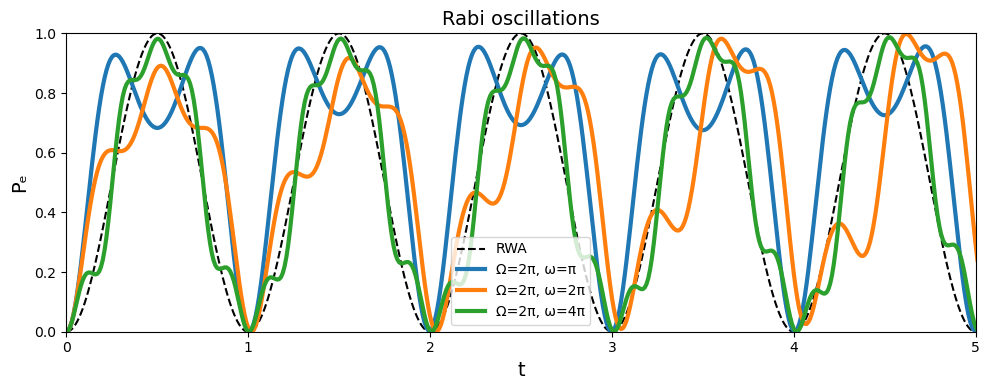

In [31]:
figure(figsize=(10,4))
plot(tspan, expect(e ⊗ dagger(e), ψ_RWA), label="RWA", color="black", linestyle="--")
plot(tspan, expect(e ⊗ dagger(e), ψ1), label="Ω=2π, ω=π", linewidth=3)
plot(tspan, expect(e ⊗ dagger(e), ψ2), label="Ω=2π, ω=2π", linewidth=3)
plot(tspan, expect(e ⊗ dagger(e), ψ3), label="Ω=2π, ω=4π", linewidth=3)
# plot(tspan, expect(e ⊗ dagger(e), ψ4), label="Ω=2π, ω=8π")

xlabel("t", fontsize=14)
ylabel("Pₑ", fontsize=14)
xlim(0.0, 5.0);
ylim(0.0, 1.0);
title("Rabi oscillations", fontsize=14)
legend()

tight_layout()

savefig("results/NoRWA.pdf", dpi=300)

 It is clearly seen that Bloch-Siegert shift cannot be computed from such messy oscillations because perturbative solution doesn't work. We can fix this by increasing $\omega$.

In [32]:
ω_vals = [1.0:0.01:25.0;] * 2*π;
Ω = 1.0 *2*π;

δω = [];

for ω ∈ ω_vals
    tspan, ψ, ψ_RWA = BlochSiegert(ω, Ω);
    
    Pe = real(expect(e ⊗ dagger(e), ψ));
    ampl = maximum(Pe);
    append!(δω, Ω * sqrt(1/ampl - 1));
end;

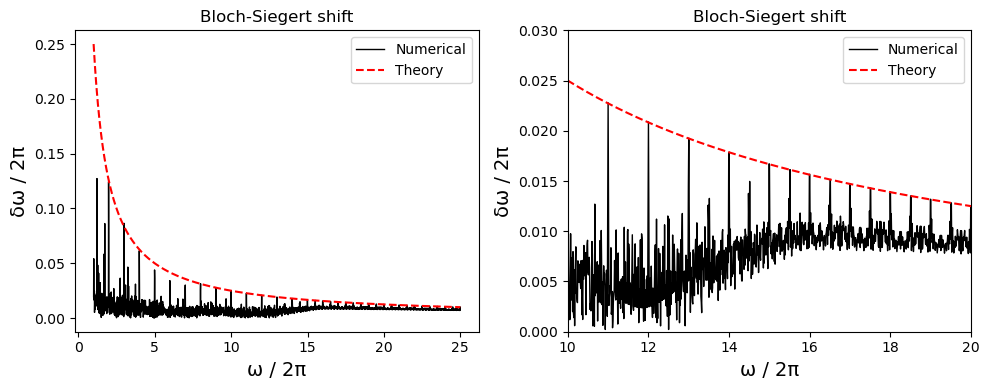

In [33]:
figure(figsize=(10,4))
    

subplot(121)
plot(ω_vals / (2*π), δω / (2*π), label="Numerical", color="black", linewidth=1.0)
plot(ω_vals / (2*π), Ω .^2 ./ (4*ω_vals) / (2*π), label="Theory", linestyle="--", color="red")
    
title("Bloch-Siegert shift")
xlabel("ω / 2π", fontsize=14)
ylabel("δω / 2π", fontsize=14)

legend()


subplot(122)
plot(ω_vals / (2*π), δω / (2*π), label="Numerical", color="black", linewidth=1.0)
plot(ω_vals / (2*π), Ω .^2 ./ (4*ω_vals) / (2*π), label="Theory", linestyle="--", color="red")
    
title("Bloch-Siegert shift")
xlabel("ω / 2π", fontsize=14)
ylabel("δω / 2π", fontsize=14)
xlim(10.0, 20.0)
ylim(0.0,0.03)

legend()


tight_layout()

savefig("results/BlochSiegert.pdf", dpi=300)

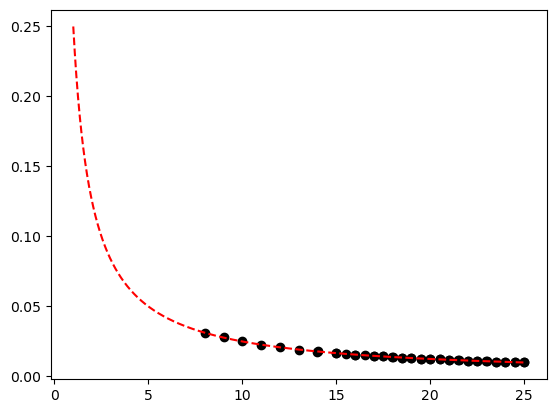

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473456c0>

In [10]:
idx = findall(x -> x < 1e-3, abs.((ω_vals / (2*π), δω / (2*π) - Ω .^2 ./ (4*ω_vals) / (2*π))[2]));

scatter(ω_vals[idx] / (2*π), δω[idx] / (2*π), label="Numerical", color="black", linewidth=1.0)
plot(ω_vals / (2*π), Ω .^2 ./ (4*ω_vals) / (2*π), label="Theory", linestyle="--", color="red")

#### Damped Rabi oscillations

In [18]:
b = NLevelBasis(2);
g = nlevelstate(b, 1);
e = nlevelstate(b, 2);

Ω = 1.0 * 2*π;
tspan = [0.0:0.01:3.0;];
ρ0 = g ⊗ dagger(g);
Δ = 0.0 * 2*π;

σge = g ⊗ dagger(e);
σeg = e ⊗ dagger(g);
J = [σge];


H = -Δ * e ⊗ dagger(e) + Ω/2 * (σge + σeg);

tout, ρ = timeevolution.master(tspan, ρ0, H, J);

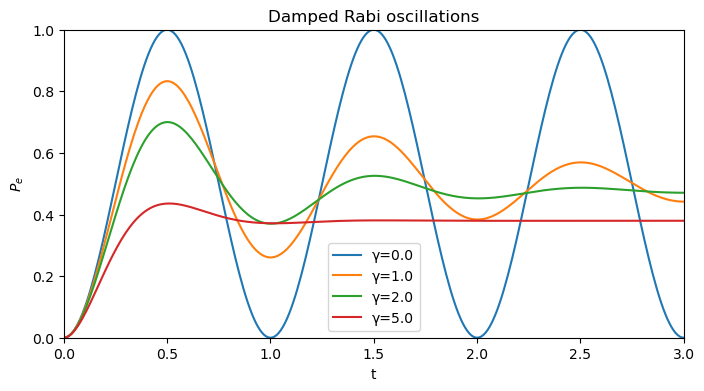

PyObject <matplotlib.legend.Legend object at 0x1477fc9a0>

In [28]:
figure(figsize=(8,4))
for γ ∈ [0.0, 1.0, 2.0, 5.0]
    tout, ρ = timeevolution.master(tspan, ρ0, H, sqrt(γ)*J);
    plot(tout, expect(e ⊗ dagger(e), ρ), label="γ=$γ")
end;


xlim(0.0, 3.0)
ylim(0.0,1.0)
xlabel("t")
ylabel("\$P_e\$")
title("Damped Rabi oscillations")
legend()